<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/2_2_chains_reducers_PRACTICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with Gemini.

Let's check that your `GEMINI_API_KEY` is set and, if not, you will be asked to enter it.

In [ ]:
from google.colab import userdata
google_api_key = userdata.get('my_stenographer_key')

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
result

AIMessage(content="Ah, you want to see the majestic orcas, or killer whales! That's a great choice.  The best place to see them in the US really depends on what you're looking for:\n\n**For guaranteed sightings:**\n\n* **San Juan Islands, Washington:** This is probably the most popular and reliable spot. You'll find orcas here year-round, but the best season is summer when they're hunting salmon. There are many tour operators offering whale watching trips.\n* **Alaska:**  You can see orcas in many parts of Alaska, particularly in the Inside Passage and around Southeast Alaska. While sightings are less guaranteed than the San Juans, the experience is truly special. \n\n**For a more adventurous experience:**\n\n* **California:**  You have a chance to see orcas off the coast of California, especially in the Monterey Bay area. However, sightings are less frequent than in the Pacific Northwest.\n* **Maine:** Orcas have been spotted in Maine waters, but they're quite rare. If you're lucky, y

In [ ]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HATE_SPEECH',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HARASSMENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False}]}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!

The `multiply` function is our tool.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools: ChatGoogleGenerativeAI = llm.bind_tools([multiply])

**Note:** Warning indicates that the title key is being generated internally, likely within LangGraph or the Gemini integration when the tool is being bound, rather than being passed explicitly. So ignore the warning


If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a function_call returned.

The function_call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}
```


In [ ]:
function_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
function_call

{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-76362628-7ba1-4a8b-9f25-7e4bdd13f2e2-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': 'd2bcd5a5-3218-4326-b92f-0ad60cb9294f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 71, 'output_tokens': 18, 'total_tokens': 89})

In [ ]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='3376122e-5a3a-4862-8796-8b0a66f96b5c'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='4d2571f1-1d06-49b7-85f3-c717a0cc76da'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='2b96448e-6a9e-41dc-b7e1-1ed706b97914')]

## Our graph

Now, lets use `MessagesState` with a graph.

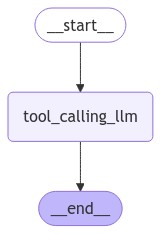

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph  = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! 👋 How can I help you today? 😊


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 and 2!")})
for m in messages['messages']:
    m.pretty_print()

{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================ Human Message =================================

Multiply 4 and 2!
================================== Ai Message ==================================
Tool Calls:
  multiply (0966360e-716e-4f1d-9394-9f3a9a39ff4a)
 Call ID: 0966360e-716e-4f1d-9394-9f3a9a39ff4a
  Args:
    b: 2.0
    a: 4.0


# **PRACTICAL PERFORM IN ROMEN URDU **

# ***Chain Overview***
Is example mein hum ek simple graph banate hain jo kuch nodes, normal edges, aur conditional edges se milkar bana hota hai. Ab hum isko LangChain ke concepts se aur zyada functional banayenge.

# **Goals**
Humara goal hai ek chain banana jo kuch core concepts ko combine kare:

Messages as Graph State: Messages ko graph ki state ke taur par use karenge.
Chat Models in Graph Nodes: Graph ke nodes mein Chat Models ko include karenge.
Tools Ko Bind Karna: Chat model ko kuch tools ke saath connect karenge.
Tools Execute Karna: Graph ke nodes mein tools ko execute karenge.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph


Yahan hum LangChain aur LangGraph install kar rahe hain taake hum inko use kar saken. Ye necessary libraries hain.

Messages in Chat Models
Messages different roles ko represent karte hain:

HumanMessage: User se aane wala message.
AIMessage: AI model se response.
SystemMessage: AI ko behavior instruct karne ke liye.
ToolMessage: Tool call se message.
Yahan hum kuch messages define karte hain:

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content="Yes, that's right.", name="Lance"))
messages.append(AIMessage(content="Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Lance"))


Is code mein hum ek conversation define karte hain, jisme AI aur human ke beech messages hain.

# Chat **Models** *italicized text*
Chat Models jaisa ki Gemini humare messages ka use karke output generate kar sakte hain.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
result = llm.invoke(messages)


Yahan hum Gemini model se conversation ko run karte hain.

# ***Tools in LangChain***
Tools tab helpful hote hain jab external systems se interact karna ho, jaise kisi API se.

Multiply function ko ek tool ke roop mein define kiya:

In [ ]:
def multiply(a: int, b: int) -> int:
    return a * b


# Tool ko model se bind karna:

In [ ]:
llm_with_tools = llm.bind_tools([multiply])


ValueError: Function must have a docstring if description not provided.

Model ab user input ko analyze karke tool use kar sakta hai, jaise kisi calculation ke liye.

# State and ***Reducers***
Messages as State: Graph mein messages ko ek state key ki tarah treat kar rahe hain:

In [ ]:
class MessagesState(TypedDict):
    messages: list[AnyMessage]


# ***Reducers: ***
Jab hum graph mein state update karte hain, toh hum reducers use karte hain taake koi value override na ho, balki append ho:

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


Yahan hum add_messages reducer use kar rahe hain jisse new messages purani list mein add ho jayein, na ke unko replace karen.

# ***Graph Build Karna***
Ab hum MessagesState ko use karke ek graph banate hain:

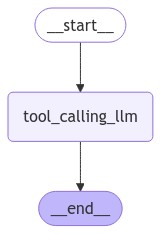

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph = builder.compile()

# View Graph
display(Image(graph.get_graph().draw_mermaid_png()))


Yahan pe hum graph banate hain jisme ek node tool_calling_llm hai, jiska kaam tools ko invoke karna hai.

# ***Graph Invoke Example***

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()


{'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'type_': 6, 'description': 'Multiply a and b.\n\nArgs:\n    a: first int\n    b: second int', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! 👋  How can I help you today? 😊


Yahan graph ko invoke karte hain aur hum dekhte hain ke model ka response kya hai. Model tools tabhi use karta hai jab use lage ke input mein kisi tool ki zaroorat hai.

Agar tumhe kisi aur cheez mein madad chahiye ho, ya kisi specific part ko aur detail mein samajhna ho toh batao!